In [78]:
import pickle
import os
import glob
from functools import reduce
import copy
import pdb

from addict import Dict
import numpy as np
import networkx as nx
from datetime import datetime

import matplotlib.pyplot as plt

import utils

## Data Logistics

In [2]:
data_config = Dict()
data_config.root_dir = "../src/covid19sim/output/sim_v2_people-100_days-20_init-0.05_seed-0_20200504-114211/"

In [3]:
def load_logs(config=None):
    config = config or data_config
    # Read files in log dir and sort them by time
    log_dir = os.path.join(config.root_dir, "data")
    files = sorted([os.path.basename(p) 
                    for p in glob.glob(os.path.join(log_dir, "*"))])
    # Load 'em up
    logs = []
    for file in files: 
        path = os.path.join(config.root_dir, "data", file)
        with open(path, "rb") as f: 
            logs.extend(pickle.load(f))
    return logs

In [4]:
def load_human_day(day_idx, human_idx, config=None): 
    config = config or data_config
    path = os.path.join(config.root_dir, "daily_outputs", 
                        str(day_idx), str(human_idx), 
                        "daily_human.pkl")
    with open(path, "rb") as f: 
        info = pickle.load(f)
    return info

In [5]:
def get_encounter_logs(logs=None): 
    logs = load_logs() if logs is None else logs
    encounter_logs = [log for log in logs if log["event_type"] == "encounter"]
    return encounter_logs

In [6]:
encounter_logs = get_encounter_logs()

## Construct an Encounter Graph

Encounter graph is a multigraph, where nodes are humans and edges are encounters between humans. Human may have multiple encounters with each other, which is why we have a multi-graph at hand. 

In [7]:
def make_encounter_graph(encounter_logs=None): 
    encounter_logs = encounter_logs or get_encounter_logs()
    encounter_graph = nx.MultiDiGraph()
    for encounter_log in encounter_logs: 
        # Ids
        human1_id = encounter_log["payload"]["unobserved"]["human1"]["human_id"]
        human2_id = encounter_log["payload"]["unobserved"]["human2"]["human_id"]
        # Write states
        human1_state = Dict()
        human2_state = Dict()
        # Infection status
        human1_state.is_infected = encounter_log["payload"]["unobserved"]["human1"]["infection_timestamp"] is not None
        human2_state.is_infected = encounter_log["payload"]["unobserved"]["human2"]["infection_timestamp"] is not None
        human1_state.got_exposed = encounter_log["payload"]["unobserved"]["human1"]["got_exposed"]
        human2_state.got_exposed = encounter_log["payload"]["unobserved"]["human2"]["got_exposed"]
        human1_state.caused_exposure = encounter_log["payload"]["unobserved"]["human1"]["exposed_other"]
        human2_state.caused_exposure = encounter_log["payload"]["unobserved"]["human2"]["exposed_other"]
        # Risk
        human1_state.risk = encounter_log["payload"]["unobserved"]["human1"]["risk"]
        human2_state.risk = encounter_log["payload"]["unobserved"]["human2"]["risk"]
        human1_state.risk_level = encounter_log["payload"]["unobserved"]["human1"]["risk_level"]
        human2_state.risk_level = encounter_log["payload"]["unobserved"]["human2"]["risk_level"]
        # Recommendations
        human1_state.rec_level = encounter_log["payload"]["unobserved"]["human1"]["rec_level"]
        human2_state.rec_level = encounter_log["payload"]["unobserved"]["human2"]["rec_level"]
        # Write stuff out
        encounter_graph.add_edge(human1_id, human2_id, encounter_log["time"], 
                                 human1_state=human1_state, human2_state=human2_state)
    return encounter_graph

The `filter_encounter_graph` function makes a new encounter graph from an existing one by keeping only the encounters that happen between the specified time limits (and removing all other encounters). 

In [8]:
def filter_encounter_graph(graph, from_time, to_time): 
    filtered = nx.MultiDiGraph()
    filtered.add_nodes_from(graph.nodes)
    for h1, h2, time in graph.edges: 
        if from_time <= time <= to_time: 
            filtered.add_edge(h1, h2, time, **graph.edges[h1, h2, time])
    return filtered

The `remove_encounter_graph_nodes` function removes nodes (and all edges) in the graph depending on a `condition_fn`. The `condition_fn` takes as input `human1_state` and `human2_state`, and outputs a bool saying if the condition is satisfied. For a given `human1` and for `reduction="and"`, if the condition is satisfied for all encounters with all encounter partners, the `human1` is marked for removal. Likewise, if `reduction="or"`, the human is marked for removal if the condition is satisfied for any encounter with any partner. `reduction` can also be a lambda. 

In [9]:
def remove_encounter_graph_nodes(graph, condition_fn, reduction=(lambda x, y: x and y)): 
    # Validate inputs
    assert callable(condition_fn)
    if isinstance(reduction, str): 
        if reduction == "and": 
            reduction = lambda x, y: x and y
        elif reduction == "or":
            reduction = lambda x, y: x or y
        else:
            raise ValueError
    assert callable(reduction)
    # Go
    node_condition_mapping = Dict()
    for node in graph.nodes: 
        conditions = []
        for neighbor in graph[node]: 
            for keys in graph[node][neighbor]: 
                conditions.append(condition_fn(**graph[node][neighbor][keys]))
        # pdb.set_trace()
        reduce(reduction, conditions)
        assert node not in node_condition_mapping
        node_condition_mapping[node] = reduce(reduction, conditions)
    nodes_to_remove = [node for node, cond in node_condition_mapping.items() if cond]
    trimmed = copy.deepcopy(graph)
    trimmed.remove_nodes_from(nodes_to_remove)
    return trimmed

`filter_edges` keeps an edge only if `condition_fn(time, human1_state, human2_state)` returns True. 

In [10]:
def filter_edges(graph, condition_fn): 
    assert callable(condition_fn)
    trimmed = nx.MultiDiGraph()
    for u, v, d in graph.edges: 
        if condition_fn(d, **graph[u][v][d]): 
            trimmed.add_edge(u, v, d, **graph[u][v][d])
    return trimmed

`collate_edges` summarizes multiple edges to a single edge with a `collate_fn`. The `collate_fn` takes as input all edges between any two nodes. 

In [31]:
def collate_edges(graph, collate_fn): 
    trimmed = nx.MultiDiGraph()
    for u in graph.nodes: 
        for v in graph[u]: 
            new_d, new_attries = collate_fn(graph[u][v])
            trimmed.add_edge(u, v, new_d, **new_attries)
    return trimmed

In [32]:
def to_digraph(graph): 
    digraph = nx.DiGraph()
    for u in graph: 
        for v in graph[u]: 
            assert len(graph[u][v]) == 1
            time = list(graph[u][v].keys())[0]
            digraph.add_edge(u, v, time=time)
    return digraph

### Functional Filters

It should be able to manipulate the graph with just these filters.

In [25]:
# Node removal
def is_not_infected(human1_state, human2_state): 
    return not human1_state["is_infected"]

# Edge filtering
def is_contagion(time, human1_state, human2_state): 
    return human2_state["got_exposed"]

# Collating
def keep_most_recent(edge_spec): 
    most_recent_date = max(list(edge_spec.keys()))
    most_recent_attries = edge_spec[most_recent_date]
    return most_recent_date, most_recent_attries

## Playtime

In [13]:
encounter_graph = make_encounter_graph(encounter_logs)

In [21]:
INTERVAL_START = datetime(2020, 2, 28)
INTERVAL_STOP = datetime(2020, 3, 10)
eg_at_interval = filter_encounter_graph(encounter_graph, INTERVAL_START, INTERVAL_STOP)

In [22]:
contagion_graph = filter_edges(eg_at_interval, is_contagion)

In [27]:
for u, v, d in sorted(contagion_graph.edges, key=lambda x: x[-1]): 
    print(f"{u} --> {v} (Time: {d})")

human:8 --> human:7 (Time: 2020-03-01 09:30:00)
human:92 --> human:93 (Time: 2020-03-01 14:59:00)
human:26 --> human:25 (Time: 2020-03-01 15:00:00)
human:100 --> human:96 (Time: 2020-03-01 17:58:00)
human:61 --> human:62 (Time: 2020-03-02 00:34:00)
human:24 --> human:23 (Time: 2020-03-02 15:32:00)
human:100 --> human:97 (Time: 2020-03-02 17:56:00)
human:92 --> human:91 (Time: 2020-03-02 20:01:00)
human:8 --> human:49 (Time: 2020-03-03 09:34:00)
human:61 --> human:60 (Time: 2020-03-04 06:58:00)
human:93 --> human:95 (Time: 2020-03-04 21:31:00)
human:96 --> human:98 (Time: 2020-03-04 22:03:00)
human:62 --> human:79 (Time: 2020-03-05 07:26:00)
human:25 --> human:70 (Time: 2020-03-05 10:30:00)
human:7 --> human:1 (Time: 2020-03-05 21:12:00)
human:49 --> human:50 (Time: 2020-03-06 01:30:00)
human:91 --> human:94 (Time: 2020-03-06 03:02:00)
human:49 --> human:52 (Time: 2020-03-06 05:39:00)
human:62 --> human:12 (Time: 2020-03-06 08:30:00)
human:23 --> human:28 (Time: 2020-03-06 16:15:00)
hum

In [33]:
contagion_digraph = to_digraph(contagion_graph)

In [64]:
contagion_subgraphs = [contagion_digraph.subgraph(sg) 
                       for sg in nx.weakly_connected_components(contagion_digraph)]

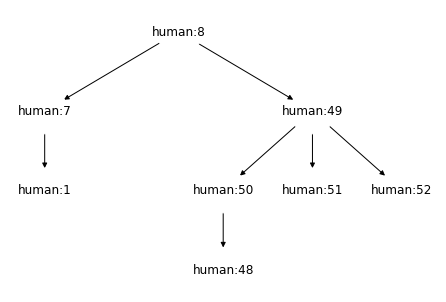

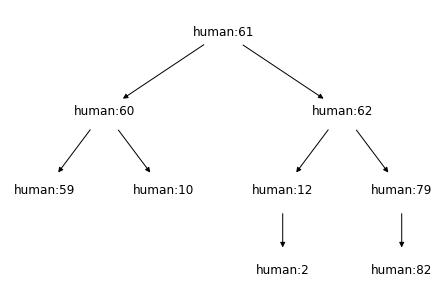

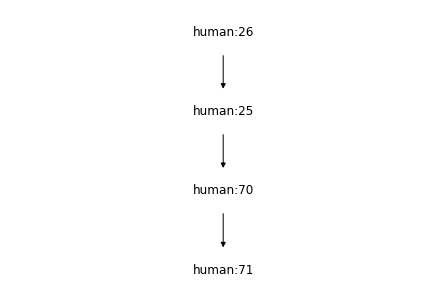

In [83]:
for k in range(3):
    nx.draw(contagion_subgraphs[k], 
            pos=utils.hierarchy_pos(contagion_subgraphs[k]), 
            with_labels=True, node_size=2000, node_color="w")
    plt.show()